In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import math 
from sklearn.preprocessing import LabelEncoder
import shap
import sweetviz
import os
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
import pickle
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score,f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
pd.options.mode.chained_assignment = None 
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

In [3]:
#Reading the Dataset
new_data=pd.read_csv('accepted_2007_to_2018Q4.csv',low_memory=False)

In [4]:
new_data.shape

(2260701, 151)

In [8]:
#Response/Target Variable 
new_data.loan_status.value_counts()

#Considering only Fully Paid, Default, Charged Off Loans.
resp=['Current']
Loan_Main = new_data[~new_data['loan_status'].isin(resp)] 
Loan_Main["loan_status"] = np.where(Loan_Main["loan_status"].str.contains("Fully"), 0, 1)

#New Dataset shape
Loan_Main.shape

# Changing employee length to numerical.
Loan_Main['emp_length'].fillna("< 1 year",inplace= True)
dict_emp_length = {'10+ years':10, '6 years':6, '4 years':4, '< 1 year':0.5, '2 years':2,'9 years':9, '5 years':5, '3 years':3, '7 years':7, '1 year':1,'8 years':8}
Loan_Main['emp_length'].replace(dict_emp_length, inplace=True)



#Seperating Loan_Main dataset into two based on Application_Type (Individual / Joint Type)
grouped = Loan_Main.groupby(Loan_Main.application_type)
individual_loan=grouped.get_group("Individual")
joint_loan=grouped.get_group("Joint App")

In [9]:
individual_loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,...,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10.0,MORTGAGE,55000.0,Not Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,...,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10.0,MORTGAGE,65000.0,Not Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,...,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,

In [11]:
col=['purpose']
enc= LabelEncoder()
individual_loan.loc[:,col]= individual_loan.loc[:,col].apply(enc.fit_transform)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9032\2600619008.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  individual_loan['issue_d'] = pd.to_datetime(individual_loan['issue_d'])


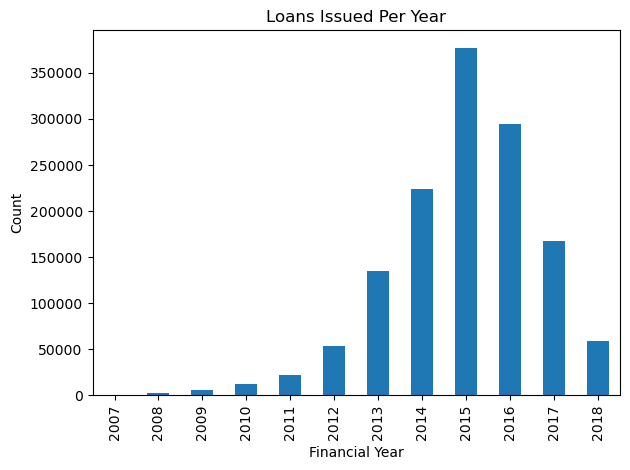

In [12]:
individual_loan['issue_d'] = pd.to_datetime(individual_loan['issue_d'])

individual_loan['issue_d'].dt.year.value_counts().sort_index().plot.bar()
plt.title('Loans Issued Per Year')
plt.xlabel('Financial Year')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

In [15]:
leak_cols = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 
             'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 
             'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 
             'initial_list_status', 'mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct','last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
             'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'sec_app_collections_12_mths_ex_med',
             'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 
             'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  
             'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq',     'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 
             'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'last_fico_range_high','last_fico_range_low','url','id','title','addr_state',
             'tot_hi_cred_lim','total_bal_ex_mort', 'total_bc_limit', 'sec_app_chargeoff_within_12_mths',
             'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 
             'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 
             'total_rev_hi_lim']
#drop leaks
filter_leaks = individual_loan.drop(columns=leak_cols, axis=1)
drop_col_count = len(leak_cols)
print("The new dataframe has {} columns and lost {} after dropping future leaks".format(filter_leaks.shape[1],
                                                                           drop_col_count))

The new dataframe has 84 columns and lost 67 after dropping future leaks


In [17]:
filter_leaks.shape

(1352767, 84)

In [18]:
#remove columns that have only 1 feature
#get unique values per feature
nunique_value = filter_leaks.apply(pd.Series.nunique)
#note columns that have single value
single_value_cols = nunique_value[nunique_value == 1].index.tolist()
print(single_value_cols)

['policy_code', 'application_type', 'hardship_type', 'deferral_term', 'hardship_length']


In [20]:
# drop the redundant columns
filter_leaks = filter_leaks.drop(columns=single_value_cols)

In [34]:
a=filter_leaks.isnull().sum()/len(filter_leaks)*100
variables = filter_leaks.columns
variable = [ ]
for i in range(0,len(filter_leaks.columns)):
    if a[i]<80:   #setting the threshold as 90% (MissingValue)
        variable.append(variables[i])
 # Dropping Columns based on missing data being more than 60% 
drop_columns1=list(set(variables) - set(variable))
non_null=filter_leaks.drop(columns=drop_columns1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9032\4276635185.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if a[i]<80:   #setting the threshold as 90% (MissingValue)


In [35]:
non_null

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,dti,earliest_cr_line,fico_range_low,fico_range_high,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,mths_since_last_major_derog,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mort_acc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,pub_rec_bankruptcies
0,3600.0,36 months,13.99,123.03,C,C4,leadman,10.0,MORTGAGE,55000.0,Not Verified,2015-12-01,0,2,190xx,5.91,Aug-2003,675.0,679.0,30.0,7.0,0.0,2765.0,29.7,13.0,30.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,3.0,1.0,4.0,1.0,69.0,69.0,0.0
1,24700.0,36 months,11.99,820.28,C,C1,Engineer,10.0,MORTGAGE,65000.0,Not Verified,2015-12-01,0,11,577xx,16.06,Dec-1999,715.0,719.0,6.0,22.0,0.0,21470.0,19.2,38.0,NaN,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,0.0,0.0,6.0,4.0,NaN,6.0,0.0
4,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3.0,MORTGAGE,104433.0,Source Verified,2015-12-01,0,6,174xx,25.37,Jun-1998,695.0,699.0,12.0,12.0,0.0,21929.0,64.5,35.0,NaN,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,2.0,1.0,3.0,6.0,12.0,12.0,0.0
5,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4.0,RENT,34000.0,Source Verified,2015-12-01,0,2,300xx,10.20,Oct-1987,690.0,694.0,NaN,5.0,0.0,8822.0,68.4,6.0,NaN,0.0,1.0,0.0,0.0,338.0,3976.0,99.0,0.0,0.0,4522.0,76.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
6,20000.0,36 months,9.17,637.58,B,B2,Vice President of Recruiting Operations,10.0,MORTGAGE,180000.0,Not Verified,2015-12-01,0,2,550xx,14.67,Jun-1990,680.0,684.0,49.0,12.0,0.0,87329.0,84.5,27.0,NaN,0.0,2.0,0.0,2.0,18.0,29433.0,63.0,2.0,3.0,13048.0,74.0,1.0,0.0,1.0,4.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,18000.0,60 months,9.49,377.95,B,B2,NaN,5.0,OWN,130000.0,Not Verified,2016-10-01,0,4,775xx,20.59,Jul-2004,735.0,739.0,NaN,17.0,0.0,23833.0,34.0,39.0,NaN,0.0,6.0,0.0,3.0,15.0,30516.0,52.0,0.0,3.0,7061.0,41.0,1.0,2.0,1.0,3.0,NaN,NaN,0.0
2260690,29400.0,60 months,13.99,683.94,C,C3,Chief Operating Officer,9.0,MORTGAGE,180792.0,Not Verified,2016-10-01,0,2,900xx,22.03,Mar-2002,705.0,709.0,NaN,16.0,0.0,77480.0,85.2,32.0,NaN,0.0,4.0,2.0,4.0,8.0,70652.0,50.0,0.0,0.0,31069.0,68.0,3.0,0.0,2.0,3.0,NaN,NaN,0.0
2260691,32000.0,60 months,14.49,752.74,C,C4,Sales Manager,3.0,MORTGAGE,157000.0,Source Verified,2016-10-01,1,4,863xx,10.34,Jun-2011,735.0,739.0,NaN,14.0,0.0,111598.0,27.4,18.0,NaN,2.0,2.0,0.0,2.0,16.0,11274.0,47.0,2.0,7.0,736.0,36.0,2.0,2.0,0.0,3.0,NaN,NaN,0.0
2260692,16000.0,60 months,12.79,362.34,C,C1,Manager,10.0,RENT,150000.0,Not Verified,2016-10-01,0,7,284xx,12.25,Aug-1997,665.0,669.0,68.0,12.0,4.0,7700.0,55.0,28.0,68.0,1.0,5.0,2.0,6.0,4.0,58097.0,79.0,0.0,3.0,4516.0,75.0,1.0,1.0,1.0,0.0,NaN,NaN,3.0


In [36]:
non_null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1352767 entries, 0 to 2260697
Data columns (total 44 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   loan_amnt                       1352767 non-null  float64       
 1   term                            1352767 non-null  object        
 2   int_rate                        1352767 non-null  float64       
 3   installment                     1352767 non-null  float64       
 4   grade                           1352767 non-null  object        
 5   sub_grade                       1352767 non-null  object        
 6   emp_title                       1268117 non-null  object        
 7   emp_length                      1352767 non-null  float64       
 8   home_ownership                  1352767 non-null  object        
 9   annual_inc                      1352763 non-null  float64       
 10  verification_status             1352767 non-nul

In [74]:
def df_object_to_num(df_obj):
    
    """Custom function to transform categorical features into numerical ones
    This function will also be applied on the testing data so that we apply the same exact kind of transformation
    """
    
    #make deep copy
    df_num = df_obj.copy()
    
    
    #keep track of columns to drop at end
    col_drop_list = ['emp_title']
    
    df_num['mort_acc'] = np.where(df_num['mort_acc'].isnull(), 0,df_num['mort_acc'])
    #pub_rec_bankruptcies
    df_num['pub_rec_bankruptcies'] = np.where(df_num['pub_rec_bankruptcies']>0, 1, 0)
    # pub_rec
    df_num['pub_rec'] = np.where(df_num['pub_rec']>0, 1, 0)
    
     ### instantiate dicts ### 
    term_to_int = {' 36 months': 1,
                   ' 60 months': 2}
    grade_to_int = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G'], np.arange(7, 0, -1)))
    #copied from above, we can write a function to generate this dict
    sub_grade_sorted = {'G5': 0, 'G4': 1, 'G3': 2, 'G2': 3, 'G1': 4,
                        'F5': 5, 'F4': 6, 'F3': 7, 'F2': 8, 'F1': 9,
                        'E5': 10, 'E4': 11, 'E3': 12, 'E2': 13, 'E1': 14,
                        'D5': 15, 'D4': 16, 'D3': 17, 'D2': 18, 'D1': 19,
                        'C5': 20, 'C4': 21, 'C3': 22, 'C2': 23, 'C1': 24,
                        'B5': 25, 'B4': 26, 'B3': 27, 'B2': 28, 'B1': 29,
                        'A5': 30, 'A4': 31, 'A3': 32, 'A2': 33, 'A1': 34}    
    home_to_int = {'MORTGAGE': 4, 'RENT': 3, 'OWN': 5,'ANY': 2,'OTHER': 1, 'NONE':0 }
    ver_stat_to_int = {'Source Verified':2,'Verified': 1,'Not Verified': 0} 
    #replacements
    df_num.replace({'term': term_to_int, 'grade':grade_to_int,'sub_grade': sub_grade_sorted, 'home_ownership':home_to_int,'verification_status':ver_stat_to_int}, inplace=True)
     #fix zip codes and keep first 3
    df_num['zip_3'] = df_num['zip_code'].str.replace('x','')
    df_num['zip_2'] = df_num['zip_3'].str[:2]
    col_drop_list.append('zip_code')
    
    #drop nans in case we missed any
    df_num = df_num.dropna(axis=0)
    
    df_num['earliest_cr_line']=  pd.to_datetime(df_num['earliest_cr_line'], infer_datetime_format=True)
    df_num['issue_d']=  pd.to_datetime(df_num['issue_d'], infer_datetime_format=True)
    credit_hist= df_num['issue_d'] - df_num['earliest_cr_line']
    df_num['credit_hist']=credit_hist.dt.days
    
    col_drop_list.append('earliest_cr_line')
    col_drop_list.append('issue_d')

    # credit_line_ratio 
    df_num['credit_line_ratio']=df_num['open_acc']/df_num['total_acc']
    col_drop_list.extend(['open_acc','total_acc'])
    
    #Balance_annual_income
    df_num['balance_annual_inc'] = df_num['loan_amnt'] / df_num['annual_inc']
    
    df_num['annual_inc']+=1
    df_num['annual_inc']=np.log(df_num['annual_inc'])
    
    df_num['fico_avg_score'] = (df_num['fico_range_high']+df_num['fico_range_low'] )/2
    col_drop_list.extend(['fico_range_high','fico_range_low'])

    df_num['inst_amnt_ratio']=df_num['installment']/df_num['loan_amnt']
    col_drop_list.extend(['installment','loan_amnt'])
    #fix zip codes and keep first 3
    df_num['zip_3'] = df_num['zip_code'].str.replace('x','')
    df_num['zip_2'] = df_num['zip_3'].str[:2]
    col_drop_list.append('zip_code')
    
    df_num  = df_num.drop(columns=col_drop_list)
    
    return df_num

In [75]:
#make entries numerical
updated_df = df_object_to_num(non_null)
updated_df.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9032\2450003171.py:44: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_num['earliest_cr_line']=  pd.to_datetime(df_num['earliest_cr_line'], infer_datetime_format=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9032\2450003171.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_num['earliest_cr_line']=  pd.to_datetime(df_num['earliest_cr_line'], infer_datetime_format=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9032\2450003171.py:45: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the defaul

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,mths_since_last_delinq,pub_rec,revol_bal,revol_util,mths_since_last_major_derog,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mort_acc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,pub_rec_bankruptcies,zip_3,zip_2,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,1,13.99,5,21,10.0,4,10.915107,0,0,2,5.91,30.0,0,2765.0,29.7,30.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,3.0,1.0,4.0,1.0,69.0,69.0,0,190,19,4505,0.538462,0.065455,677.0,0.034175
21,2,14.85,5,20,10.0,4,10.778977,0,0,1,33.18,33.0,1,19108.0,29.6,33.0,1.0,2.0,1.0,2.0,6.0,12221.0,91.0,1.0,4.0,14982.0,65.0,0.0,0.0,1.0,2.0,76.0,76.0,0,297,29,8949,0.578947,0.333333,687.0,0.023712
30,1,12.88,5,23,10.0,4,11.082158,0,1,11,18.96,33.0,1,5157.0,54.3,55.0,2.0,2.0,0.0,0.0,27.0,34624.0,68.0,2.0,2.0,739.0,64.0,0.0,5.0,0.0,0.0,33.0,33.0,0,354,35,10957,0.350000,0.246154,677.0,0.033636
32,1,10.78,6,26,1.0,3,11.492733,0,0,2,24.04,33.0,1,20462.0,62.8,69.0,0.0,4.0,1.0,3.0,9.0,82819.0,66.0,1.0,2.0,12597.0,65.0,1.0,1.0,0.0,8.0,69.0,69.0,0,993,99,5051,0.384615,0.122449,692.0,0.032635
57,2,11.99,5,24,10.0,4,11.759793,2,0,4,6.46,46.0,0,14277.0,27.4,56.0,1.0,11.0,0.0,0.0,28.0,35367.0,49.0,0.0,1.0,5020.0,40.0,1.0,4.0,0.0,5.0,46.0,46.0,0,200,20,9434,0.369565,0.273438,687.0,0.022239


In [77]:
scale_cols=['term', 'int_rate', 'grade', 'sub_grade', 'emp_length','home_ownership', 'annual_inc', 'verification_status','purpose', 'dti',
            'revol_bal','revol_util', 'mort_acc','credit_hist', 'credit_line_ratio', 'balance_annual_inc','fico_avg_score','inst_amnt_ratio']

In [78]:
#eliminate binary features
updated_df = updated_df[scale_cols]

updated_df.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,revol_bal,revol_util,mort_acc,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,1,13.99,5,21,10.0,4,10.915107,0,2,5.91,2765.0,29.7,1.0,4505,0.538462,0.065455,677.0,0.034175
21,2,14.85,5,20,10.0,4,10.778977,0,1,33.18,19108.0,29.6,2.0,8949,0.578947,0.333333,687.0,0.023712
30,1,12.88,5,23,10.0,4,11.082158,0,11,18.96,5157.0,54.3,0.0,10957,0.350000,0.246154,677.0,0.033636
32,1,10.78,6,26,1.0,3,11.492733,0,2,24.04,20462.0,62.8,8.0,5051,0.384615,0.122449,692.0,0.032635
57,2,11.99,5,24,10.0,4,11.759793,2,4,6.46,14277.0,27.4,5.0,9434,0.369565,0.273438,687.0,0.022239


In [84]:
updated_df

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,revol_bal,revol_util,mort_acc,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,1,13.99,5,21,10.0,4,10.915107,0,2,5.91,2765.0,29.7,1.0,4505,0.538462,0.065455,677.0,0.034175
21,2,14.85,5,20,10.0,4,10.778977,0,1,33.18,19108.0,29.6,2.0,8949,0.578947,0.333333,687.0,0.023712
30,1,12.88,5,23,10.0,4,11.082158,0,11,18.96,5157.0,54.3,0.0,10957,0.350000,0.246154,677.0,0.033636
32,1,10.78,6,26,1.0,3,11.492733,0,2,24.04,20462.0,62.8,8.0,5051,0.384615,0.122449,692.0,0.032635
57,2,11.99,5,24,10.0,4,11.759793,2,4,6.46,14277.0,27.4,5.0,9434,0.369565,0.273438,687.0,0.022239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260603,2,14.49,5,21,10.0,4,11.156265,2,4,15.40,2334.0,13.4,2.0,4626,0.578947,0.228571,692.0,0.023523
2260642,2,12.79,5,24,2.0,4,11.982935,1,2,17.76,41141.0,68.6,3.0,4841,0.333333,0.218750,672.0,0.022646
2260657,2,12.79,5,24,2.0,5,11.784554,0,2,9.65,18233.0,50.8,0.0,4536,0.600000,0.146331,677.0,0.022646
2260667,2,14.49,5,21,0.5,3,11.264477,2,2,13.02,13775.0,63.8,0.0,8219,0.384615,0.248718,667.0,0.023523


#set fraction
frac = 0.85
#get fractions and make deep copy
df_train = Individual_Loan.loc[Individual_Loan['issue_d']  < Individual_Loan['issue_d'].quantile(frac)]
df_test =  Individual_Loan.loc[Individual_Loan['issue_d'] >= Individual_Loan['issue_d'].quantile(frac)]